# Style GAN


This notebook implements a Style Transfer GAN that generates paintings.

In [87]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from kaggle.api.kaggle_api_extended import KaggleApi
import kaggle
import zipfile
import os
import time
from PIL import Image


import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.4.1


# Data Loading


First, be sure to go to your Kaggle profile and create an API token. Make sure it's in your .kaggle folder. Also, you must join this competition to accept the terms and conditions before you can download the data: https://www.kaggle.com/c/gan-getting-started/data

In [ ]:
if (input("Are you running in collab? (y/n): ") == 'y'):
    print("Running Collab imports")
    # Upload Kaggle.json
    from google.colab import files 
    files.upload()
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
else:
    print("Ignoring collab code")

Are you running in collab? (y/n): y
Running Collab imports


Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
api = KaggleApi()
api.authenticate()
if (not os.path.exists('./imgdata')):
    api.competition_download_files('gan-getting-started', path='./imgdata')
    print("Download complete!")

Download complete!


In [3]:
# Unzip the folder
print("Unzipping images...")
zp = zipfile.ZipFile("./imgdata/gan-getting-started.zip", "r")
zp.extractall("./imgdata/gan-getting-started")
zp.close()
print("Unzipped!")

Unzipping images...
Unzipped!


In [4]:
IMG_PATH = "imgdata/gan-getting-started"

In [5]:
MONET_FILENAMES = tf.io.gfile.glob(str(IMG_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(IMG_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [6]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [7]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [8]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [9]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

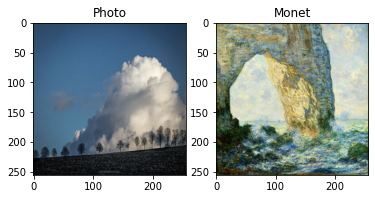

In [10]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## Building the Generator 

In [88]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [12]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [13]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Building the Discriminator

In [120]:
def Discriminator():

    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # Implementation of AlexNet. See paper:
    # https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks
    
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    
    # (None, 256, 256, 3)
    x = inp
    
    # Surround input with one layer of zeros
    # (None, 258, 258, 3)
    zero_pad1 = layers.ZeroPadding2D()(x)
    
    # 11 x 11 kernel across image, 96 kernels
    # (None, 62, 62, 96)
    conv1 = layers.Conv2D(96, 11, activation="relu", strides=4)(zero_pad1)
    
    # 3 x 3 overlapping max pooling
    # (None, 31, 31, 96)
    pool1 = tf.nn.max_pool2d(conv1, 3, 2, "SAME")
    
    # Local response normalization
    # (None, 31, 31, 96)
    norm1 = tf.nn.local_response_normalization(pool1, depth_radius=2, bias=2, alpha=1e-4, beta=0.75)
    
    # Surround with one layer of zeros
    # (None, 33, 33, 96)
    zero_pad2 = layers.ZeroPadding2D()(pool1)
    
    # 5 x 5 kernel across image, 256 kernels
    # (None, 29, 29, 256)
    conv2 = layers.Conv2D(256, 5, activation="relu")(zero_pad2)
    
    # 3 x 3 overlapping max pooling (z = 3, s = 2)
    # (None, 15, 15, 256)
    pool2 = tf.nn.max_pool2d(conv2, 3, 2, "SAME")
    
    # Local response normalization
    # (None, 15, 15, 256)
    norm2 = tf.nn.local_response_normalization(pool2, depth_radius=2, bias=2, alpha=1e-4, beta=0.75)
    
    # Surround with one layer of zeros
    # (None, 17, 17, 256)
    zero_pad3 = layers.ZeroPadding2D()(norm2)
    
    # 3 x 3 kernel across image, 384 kernels
    # (None, 15, 15, 384)
    conv3 = layers.Conv2D(384, 3, activation="relu")(zero_pad3)
   
    # Surround with one layer of zeros
    # (None, 17, 17, 384)
    zero_pad4 = layers.ZeroPadding2D()(conv3)
    
    # 3 x 3 kernel across image, 384 kernels
    # (None, 15, 15, 384)
    conv4 = layers.Conv2D(384, 3, activation="relu")(zero_pad4)
    
    # Surround with one layer of zeros
    # (None, 17, 17, 384)
    zero_pad5 = layers.ZeroPadding2D()(conv4)    
    
    # 3 x 3 kernel across image, 256 kernels
    # (None, 15, 15, 256)
    conv5 = layers.Conv2D(256, 3, activation="relu")(zero_pad5)
    
    # Bilinear upsampling from 15 x 15 to 30 x 30
    # (None, 30, 30, 256)
    upsampling1 = layers.UpSampling2D(size=(2,2), interpolation="bilinear")(conv5)

    # 1 x 1 kernel across image, 1 kernel
    # (None, 30, 30, 1)
    last = layers.Conv2D(1, 1, strides=1, kernel_initializer=initializer)(upsampling1)
    
    return tf.keras.Model(inputs=inp, outputs=last)

print(Discriminator().summary())

Model: "model_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
zero_padding2d_455 (ZeroPadd (None, 258, 258, 3)       0         
_________________________________________________________________
conv2d_715 (Conv2D)          (None, 62, 62, 96)        34944     
_________________________________________________________________
tf.nn.max_pool2d_109 (TFOpLa (None, 31, 31, 96)        0         
_________________________________________________________________
zero_padding2d_456 (ZeroPadd (None, 33, 33, 96)        0         
_________________________________________________________________
conv2d_716 (Conv2D)          (None, 29, 29, 256)       614656    
_________________________________________________________________
tf.nn.max_pool2d_110 (TFOpLa (None, 15, 15, 256)       0  

In [15]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

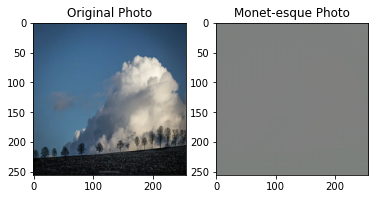

In [16]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

## Building the CycleGAN Model

In [17]:
class CycleGan(keras.Model):
    
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Define Loss Functions

In [18]:
with strategy.scope():
    
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [19]:
with strategy.scope():
    
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                    reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)

In [20]:
#We want our original photo and the twice transformed photo to be similar to one another. 
#Thus, we can calculate the cycle consistency loss be finding the average of their difference.

with strategy.scope():
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [21]:
with strategy.scope():
    
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Model Training


## Train the CycleGAN

In [22]:
with strategy.scope():
    
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
with strategy.scope():
    
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [24]:
# Get time to export
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

# Get model weights to save
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Checkpoints can be reloaded and used in the model as explained here:
# https://www.tensorflow.org/tutorials/keras/save_and_load


history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25,
    callbacks=[time_callback, cp_callback]
)

Epoch 1/25
300/300 [==============================] - 319s 803ms/step - monet_gen_loss: 5.1648 - photo_gen_loss: 5.4191 - monet_disc_loss: 0.6665 - photo_disc_loss: 0.6233

Epoch 00001: saving model to training_1\cp.ckpt
Epoch 2/25
300/300 [==============================] - 235s 783ms/step - monet_gen_loss: 3.5752 - photo_gen_loss: 3.7975 - monet_disc_loss: 0.6782 - photo_disc_loss: 0.6005

Epoch 00002: saving model to training_1\cp.ckpt
Epoch 3/25
300/300 [==============================] - 235s 782ms/step - monet_gen_loss: 3.5273 - photo_gen_loss: 3.7103 - monet_disc_loss: 0.6521 - photo_disc_loss: 0.6176

Epoch 00003: saving model to training_1\cp.ckpt
Epoch 4/25
300/300 [==============================] - 234s 780ms/step - monet_gen_loss: 3.4472 - photo_gen_loss: 3.6611 - monet_disc_loss: 0.6472 - photo_disc_loss: 0.6052

Epoch 00004: saving model to training_1\cp.ckpt
Epoch 5/25
300/300 [==============================] - 234s 779ms/step - monet_gen_loss: 3.3040 - photo_gen_loss: 3.4

## Visualize our Monet-esque photos

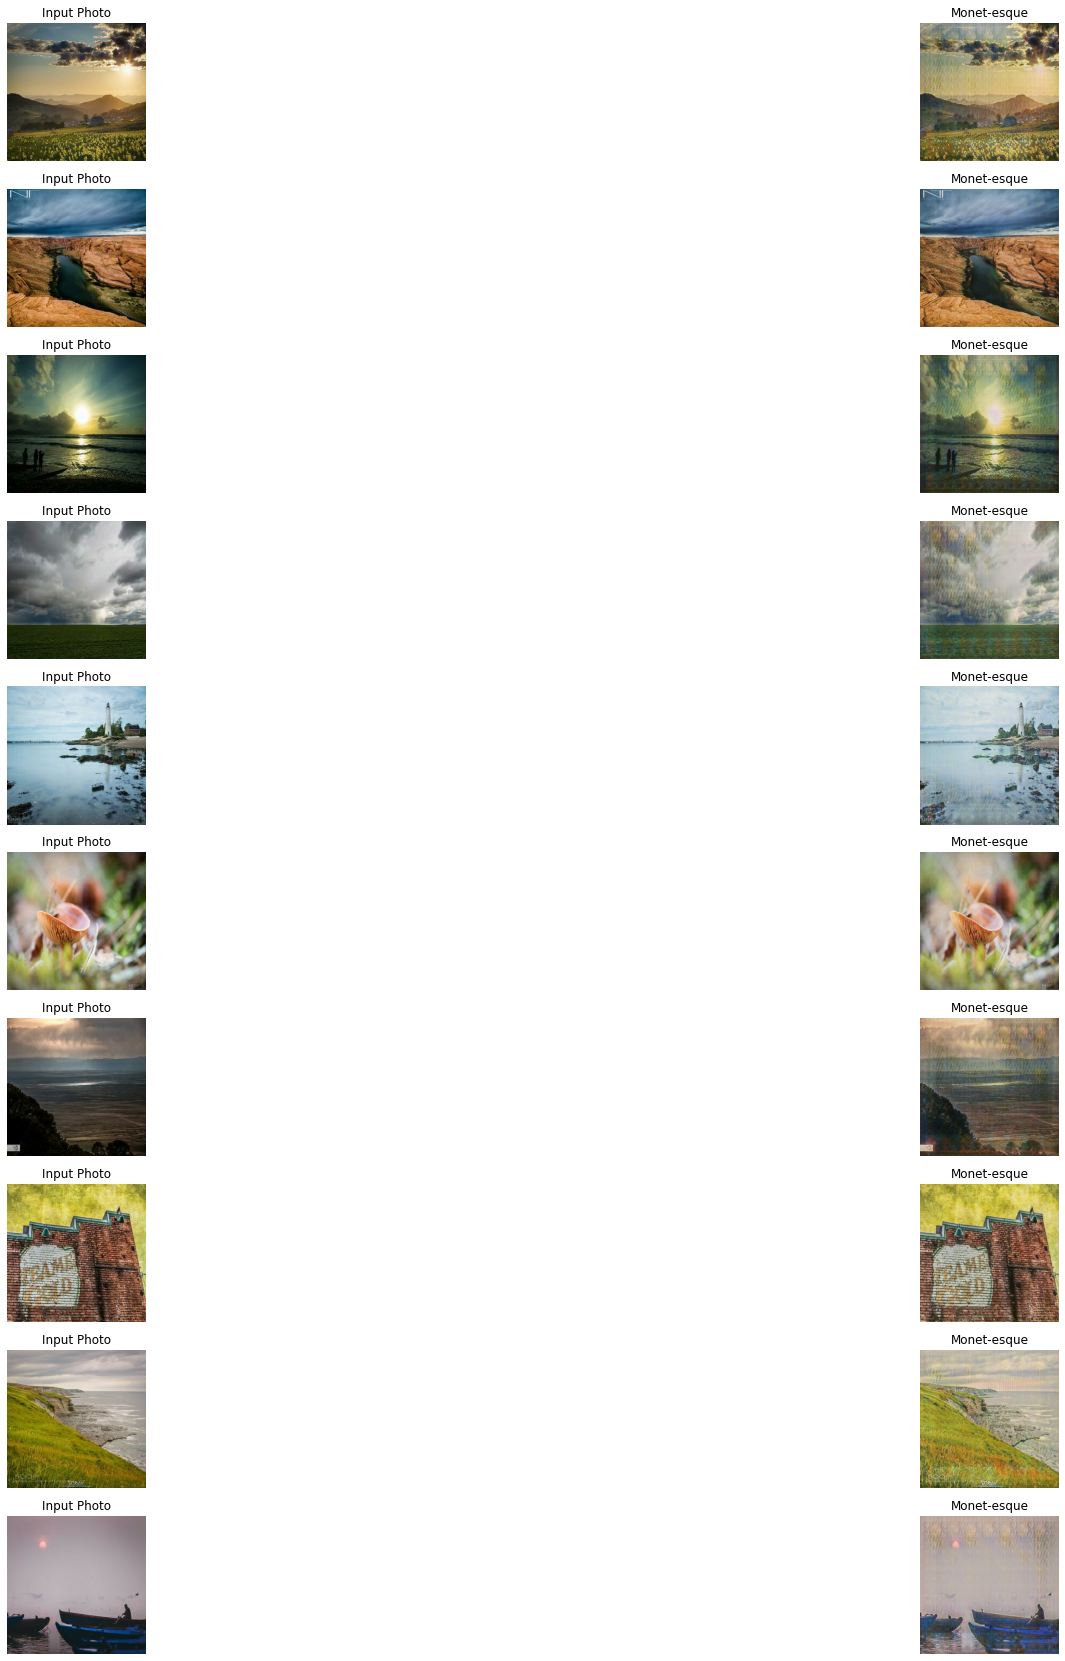

In [34]:
# Make a directory to save the images to
if not os.path.exists('dataoutput'):
        os.makedirs('dataoutput')

_, ax = plt.subplots(10, 2, figsize=(30, 30))

# Make sure to get the same images every time
d = 'imgdata/gan-getting-started/photo_jpg'
for i, img_path in enumerate(sorted(os.listdir(d))[0:10]):
    # Get the full path and load the image 
    img_path  = full_path = os.path.join(d, img_path)
    img = tf.io.read_file(img_path)
    img = decode_image(img)
    img = tf.expand_dims(
        img, axis=0
    )
    
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    # Save the image
    im = Image.fromarray(img)
    im.save("dataoutput/img{}.jpeg".format(i))
    pr = Image.fromarray(prediction)
    pr.save("dataoutput/pr{}.jpeg".format(i))

plt.show()

# Results

In [26]:
# Export training data to CSV
import csv
w = csv.writer(open("model_YOURNAMEHERE.csv", "w"))
w.writerow(['Label', 'Data'])
# Write the time as well
w.writerow(['time', time_callback.times])
for key, val in history.history.items():
    w.writerow([key, val])

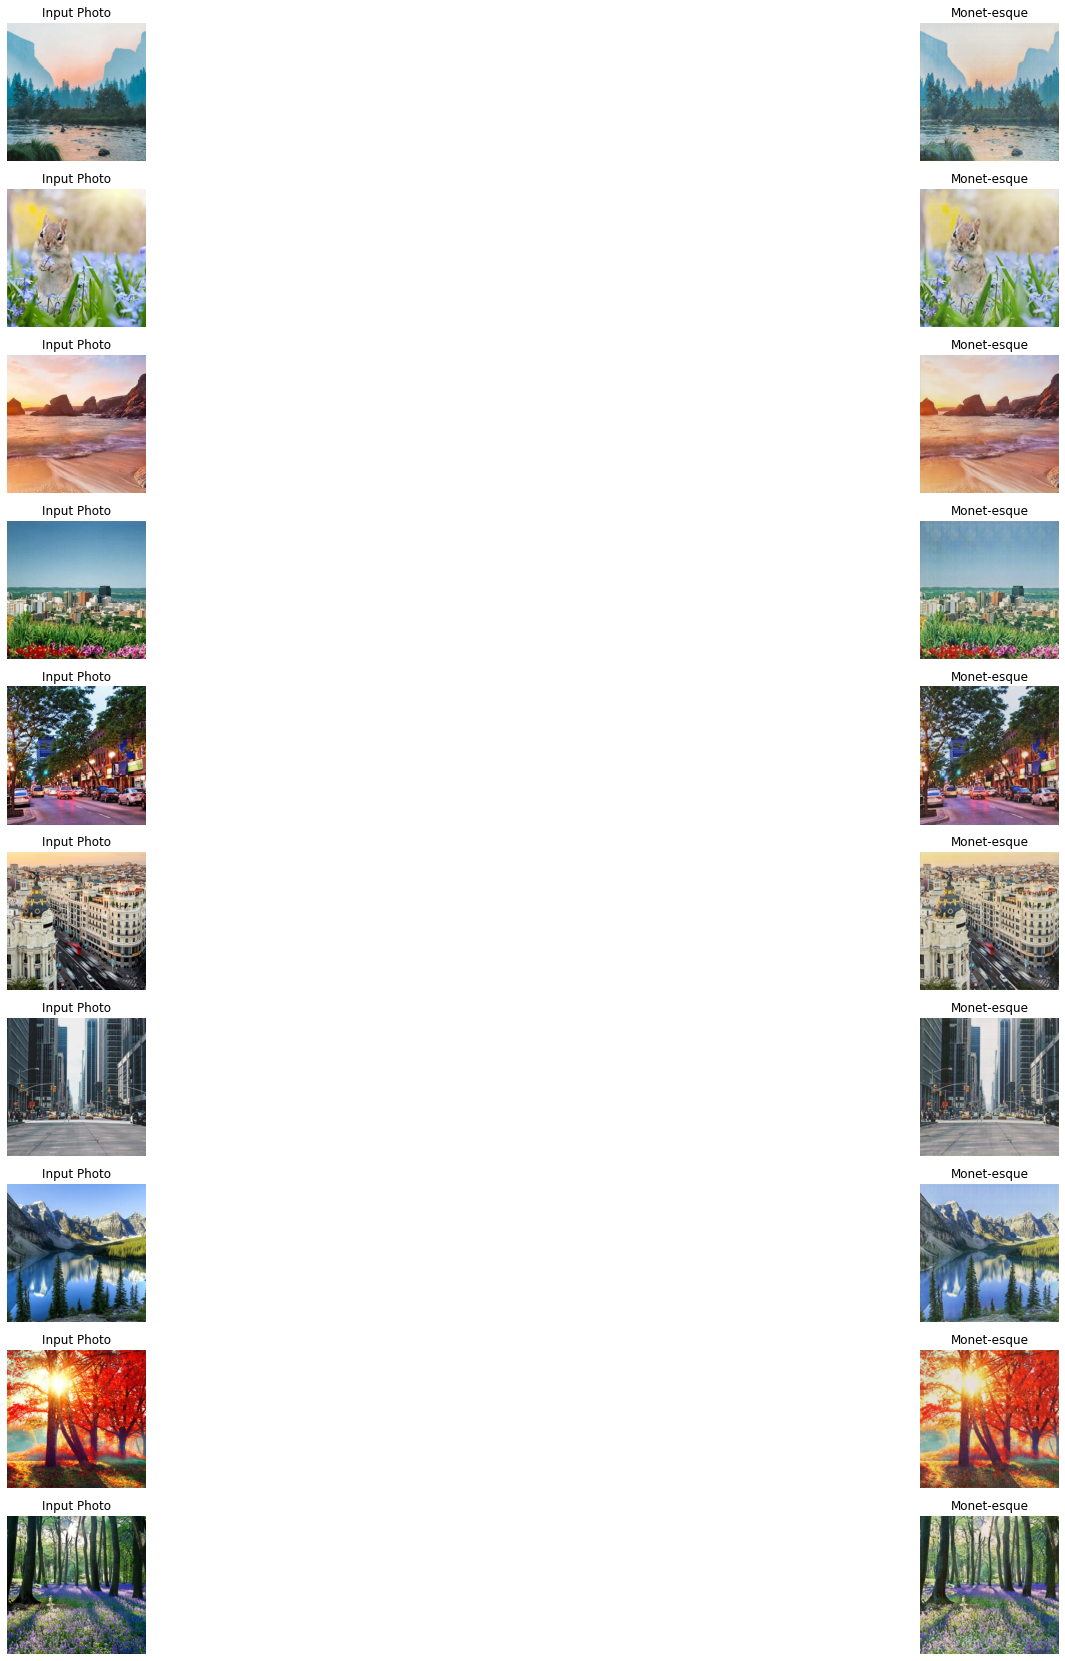

In [35]:
# Try with a set of base images

# Make a directory to save the images to
if not os.path.exists('testoutput'):
        os.makedirs('testoutput')
        
_, ax = plt.subplots(10, 2, figsize=(30, 30))
d = 'imgtest'
for i, img_path in enumerate(os.listdir(d)):
    # Get the full path and load the image
    img_path  = full_path = os.path.join(d, img_path)
    img = tf.io.read_file(img_path)
    img = decode_image(img)
    img = tf.expand_dims(
        img, axis=0
    )

    # Get the prediction and alter the images
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    # Output into a graph
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    # Save the image
    im = Image.fromarray(img)
    im.save("testoutput/imgtest{}.jpeg".format(i))
    pr = Image.fromarray(prediction)
    pr.save("testoutput/prtest{}.jpeg".format(i))